<a href="https://colab.research.google.com/github/nisho06/Pump_It_Up_Challenge/blob/main/Pump_it_up_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [161]:
pip install shap

In [162]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import catboost
from catboost import *
import shap
shap.initjs()

In [163]:
X_train = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv',index_col ='id')
y_train = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv',index_col='id')
X_test = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv',index_col = 'id')

In [164]:
print(X_train.shape, y_train.shape, X_test.shape)

(59400, 39) (59400, 1) (14850, 39)


In [165]:
X_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [166]:
y_train.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [167]:
X_train.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [168]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

In [169]:
categorical_col_and_categories_count = [[col,X_train[col].nunique()] for col in X_train.columns if (X_train[col].dtype == 'object')]
categorical_col_and_categories_count

[['date_recorded', 356],
 ['funder', 1897],
 ['installer', 2145],
 ['wpt_name', 37400],
 ['basin', 9],
 ['subvillage', 19287],
 ['region', 21],
 ['lga', 125],
 ['ward', 2092],
 ['public_meeting', 2],
 ['recorded_by', 1],
 ['scheme_management', 12],
 ['scheme_name', 2696],
 ['permit', 2],
 ['extraction_type', 18],
 ['extraction_type_group', 13],
 ['extraction_type_class', 7],
 ['management', 12],
 ['management_group', 5],
 ['payment', 7],
 ['payment_type', 7],
 ['water_quality', 8],
 ['quality_group', 6],
 ['quantity', 5],
 ['quantity_group', 5],
 ['source', 10],
 ['source_type', 7],
 ['source_class', 3],
 ['waterpoint_type', 7],
 ['waterpoint_type_group', 6]]

In [170]:
X_train['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [171]:
def group_plot_with_status(col, X_train):

  X = X_train[col].unique()
  functional = []
  non_functional = []
  functional_needs_repair = []

  for i in X:
    functional.append((((y_train['status_group'] == 'functional') & (X_train[col] == i)) == True).sum())
    non_functional.append((((y_train['status_group'] == 'non functional') & (X_train[col] == i)) == True).sum())
    functional_needs_repair.append((((y_train['status_group'] == 'functional needs repair') & (X_train[col] == i)) == True).sum())

  functional = np.array(functional)
  non_functional = np.array(non_functional)
  functional_needs_repair = np.array(functional_needs_repair)

  functional_new = functional / (functional+non_functional+functional_needs_repair)
  non_functional_new = non_functional / (functional+non_functional+functional_needs_repair)
  functional_needs_repair_new = functional_needs_repair / (functional+non_functional+functional_needs_repair)

  return X, functional_new, non_functional_new, functional_needs_repair_new


In [172]:
def plot_graph(col, X_train):
  X, functional_new, non_functional_new, functional_needs_repair_new = group_plot_with_status(col, X_train)
  x = np.arange(len(X))
  width = 0.2

  ax =plt.subplots(figsize=(12,5))
  rects1 = plt.bar(x, functional_new, width)
  rects2 = plt.bar(x+width, non_functional_new, width)
  rects3 = plt.bar(x+width*2, functional_needs_repair_new, width)

  plt.ylabel('Count')
  plt.title('How status group depends on each category in '+col)
  plt.xticks(x+width,X)
  plt.legend((rects1,rects2,rects3),('functional','non functional','functional needs repair'))

  plt.show()

In [173]:
X_train['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

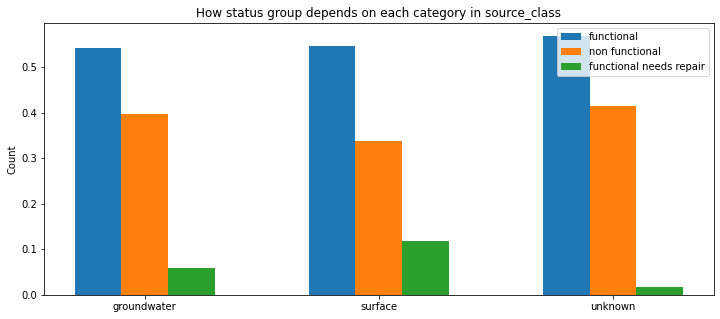

In [174]:
plot_graph('source_class', X_train)

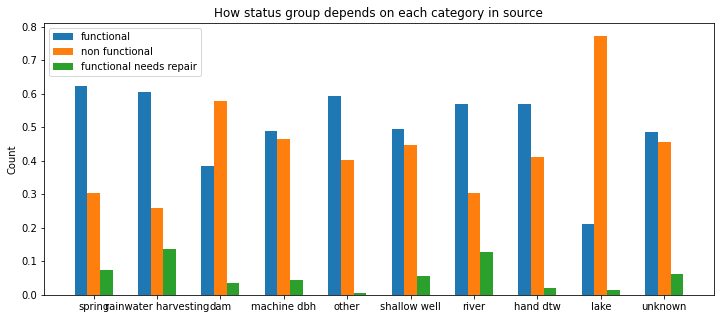

In [175]:
plot_graph('source', X_train)

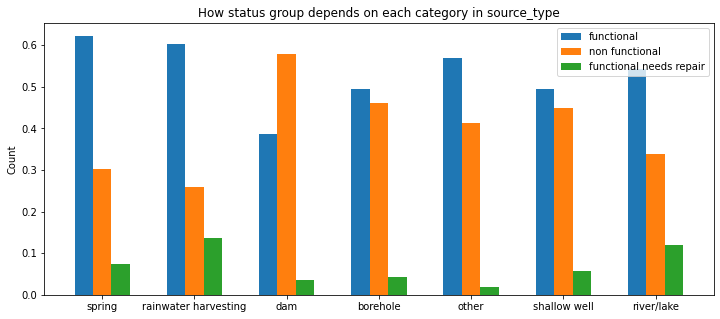

In [176]:
plot_graph('source_type', X_train)

In [177]:
remove_columns = ['amount_tsh','funder','num_private','region','scheme_name','recorded_by','extraction_type','extraction_type_class','management','payment_type','water_quality','quantity','source_class','source','waterpoint_type_group']

In [178]:
X_train.isnull().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [179]:
X_train.shape[1]-len(remove_columns)

24

In [180]:
dropped_X_train = X_train.drop(remove_columns,axis=1)
dropped_X_test = X_test.drop(remove_columns,axis=1)

In [181]:
null_columns_categorical = [col for col in dropped_X_train.columns if (dropped_X_train[col].isnull().sum()>0) and (dropped_X_train[col].dtype=='object')]

In [182]:
null_columns_categorical

['installer', 'subvillage', 'public_meeting', 'scheme_management', 'permit']

In [183]:
X_train_plus = dropped_X_train[null_columns_categorical].copy()
X_test_plus = dropped_X_test[null_columns_categorical].copy()

In [184]:
for col in null_columns_categorical:
  X_train_plus[col+'_was_missing'] = X_train_plus[col].isnull()
  X_test_plus[col+'_was_missing'] = X_test_plus[col].isnull()

In [185]:
X_train_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   installer                      55745 non-null  object
 1   subvillage                     59029 non-null  object
 2   public_meeting                 56066 non-null  object
 3   scheme_management              55523 non-null  object
 4   permit                         56344 non-null  object
 5   installer_was_missing          59400 non-null  bool  
 6   subvillage_was_missing         59400 non-null  bool  
 7   public_meeting_was_missing     59400 non-null  bool  
 8   scheme_management_was_missing  59400 non-null  bool  
 9   permit_was_missing             59400 non-null  bool  
dtypes: bool(5), object(5)
memory usage: 3.0+ MB


In [186]:
my_imputer = SimpleImputer(strategy = 'most_frequent')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test_plus))

In [187]:
imputed_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       59400 non-null  object
 1   1       59400 non-null  object
 2   2       59400 non-null  object
 3   3       59400 non-null  object
 4   4       59400 non-null  object
 5   5       59400 non-null  object
 6   6       59400 non-null  object
 7   7       59400 non-null  object
 8   8       59400 non-null  object
 9   9       59400 non-null  object
dtypes: object(10)
memory usage: 4.5+ MB


In [188]:
imputed_X_train.columns = X_train_plus.columns
imputed_X_test.columns = X_test_plus.columns

imputed_X_train.index = X_train_plus.index
imputed_X_test.index = X_test_plus.index

In [189]:
imputed_X_train.head()

,installer,subvillage,public_meeting,scheme_management,permit,installer_was_missing,subvillage_was_missing,public_meeting_was_missing,scheme_management_was_missing,permit_was_missing
id,,,,,,,,,,
69572,Roman,Mnyusi B,True,VWC,False,False,False,False,False,False
8776,GRUMETI,Nyamara,True,Other,True,False,False,True,False,False
34310,World vision,Majengo,True,VWC,True,False,False,False,False,False
67743,UNICEF,Mahakamani,True,VWC,True,False,False,False,False,False
19728,Artisan,Kyanyamisa,True,VWC,True,False,False,False,True,False


In [190]:
null_columns_categorical_negation = [col for col in dropped_X_train.columns if (col not in null_columns_categorical)]

In [191]:
null_columns_categorical_negation

['date_recorded',
 'gps_height',
 'longitude',
 'latitude',
 'wpt_name',
 'basin',
 'region_code',
 'district_code',
 'lga',
 'ward',
 'population',
 'construction_year',
 'extraction_type_group',
 'management_group',
 'payment',
 'quality_group',
 'quantity_group',
 'source_type',
 'waterpoint_type']

In [192]:
imputed_X_train = pd.concat([imputed_X_train,dropped_X_train[null_columns_categorical_negation]],axis=1)
imputed_X_test = pd.concat([imputed_X_test,dropped_X_test[null_columns_categorical_negation]],axis=1)

In [193]:
print (imputed_X_train.shape, imputed_X_test.shape)

(59400, 29) (14850, 29)


In [194]:
categorical_col_with_0 = [[col,(imputed_X_train[col]=='0').sum()] for col in imputed_X_train.columns if (imputed_X_train[col]=='0').sum()> 0]

In [195]:
categorical_col_with_0

[['installer', 777]]

In [196]:
most_frequent_installer = imputed_X_train['installer'].value_counts().idxmax()

In [197]:
most_frequent_installer

'DWE'

In [198]:
imputed_X_train['installer'] = imputed_X_train['installer'].replace(['0'],most_frequent_installer)
imputed_X_test['installer'] = imputed_X_test['installer'].replace(['0'],most_frequent_installer)

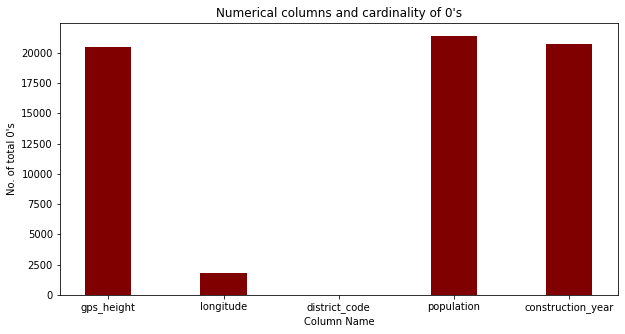

In [199]:
cols_with_missing_values_numerical = []
dict_with_missing_values_numerical = {}
for col in imputed_X_train.columns:
  if (imputed_X_train[col] == 0).sum()>0 and imputed_X_train[col].dtype != 'object' :
    dict_with_missing_values_numerical[col] =  (imputed_X_train[col] == 0).sum()
    cols_with_missing_values_numerical.append(col)

fig = plt.figure(figsize = (10, 5))

plt.bar(list(dict_with_missing_values_numerical.keys()), list(dict_with_missing_values_numerical.values()), color ='maroon',
        width = 0.4)
 
plt.xlabel("Column Name")
plt.ylabel("No. of total 0's")
plt.title("Numerical columns and cardinality of 0's")
plt.show()

In [200]:
dict_with_missing_values_numerical

{'construction_year': 20709,
 'district_code': 23,
 'gps_height': 20438,
 'longitude': 1812,
 'population': 21381}

In [201]:
cols_with_missing_values_numerical

['gps_height', 'longitude', 'district_code', 'population', 'construction_year']

In [202]:
cols_with_missing_values_numerical_negation = [col for col in imputed_X_train.columns if (col not in cols_with_missing_values_numerical)]

In [203]:
cols_with_missing_values_numerical_negation

['installer',
 'subvillage',
 'public_meeting',
 'scheme_management',
 'permit',
 'installer_was_missing',
 'subvillage_was_missing',
 'public_meeting_was_missing',
 'scheme_management_was_missing',
 'permit_was_missing',
 'date_recorded',
 'latitude',
 'wpt_name',
 'basin',
 'region_code',
 'lga',
 'ward',
 'extraction_type_group',
 'management_group',
 'payment',
 'quality_group',
 'quantity_group',
 'source_type',
 'waterpoint_type']

In [204]:
imputed_X_train[cols_with_missing_values_numerical]

,gps_height,longitude,district_code,population,construction_year
id,,,,,
69572,1390,34.938093,5,109,1999
8776,1399,34.698766,2,280,2010
34310,686,37.460664,4,250,2009
67743,263,38.486161,63,58,1986
19728,0,31.130847,1,0,0
...,...,...,...,...,...
60739,1210,37.169807,5,125,1999
27263,1212,35.249991,4,56,1996
37057,0,34.017087,7,0,0


In [205]:
X_train_numerical = imputed_X_train[cols_with_missing_values_numerical].copy()
X_test_numerical = imputed_X_test[cols_with_missing_values_numerical].copy()

my_imputer_numerical = SimpleImputer(missing_values=0)
imputed_X_train_plus = pd.DataFrame(my_imputer_numerical.fit_transform(X_train_numerical))
imputed_X_test_plus = pd.DataFrame(my_imputer_numerical.transform(X_test_numerical))

imputed_X_train_plus.columns = X_train_numerical.columns
imputed_X_test_plus.columns = X_test_numerical.columns

imputed_X_train_plus.index = X_train_numerical.index
imputed_X_test_plus.index = X_test_numerical.index

In [206]:
imputed_X_train_plus

,gps_height,longitude,district_code,population,construction_year
id,,,,,
69572,1390.000000,34.938093,5.0,109.000000,1999.000000
8776,1399.000000,34.698766,2.0,280.000000,2010.000000
34310,686.000000,37.460664,4.0,250.000000,2009.000000
67743,263.000000,38.486161,63.0,58.000000,1986.000000
19728,1018.860839,31.130847,1.0,281.087167,1996.814686
...,...,...,...,...,...
60739,1210.000000,37.169807,5.0,125.000000,1999.000000
27263,1212.000000,35.249991,4.0,56.000000,1996.000000
37057,1018.860839,34.017087,7.0,281.087167,1996.814686


In [207]:
imputed_X_train_final = pd.concat([imputed_X_train_plus,imputed_X_train[cols_with_missing_values_numerical_negation]],axis=1)
imputed_X_test_final = pd.concat([imputed_X_test_plus,imputed_X_test[cols_with_missing_values_numerical_negation]],axis=1)

In [208]:
y_train.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [209]:
y_train['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [210]:
label_encoder = preprocessing.LabelEncoder()
y_train['status_group']= label_encoder.fit_transform(y_train['status_group'])

In [211]:
catogrical_features=[col for col in imputed_X_train_final.columns if imputed_X_train_final[col].dtype=='object']
len(catogrical_features)

22

In [212]:
y_train.head()

,status_group
id,
69572,0
8776,0
34310,0
67743,2
19728,0


In [213]:
y_train['status_group'].value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

In [215]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.fit(imputed_X_train_final,
          y_train,cat_features = catogrical_features)

Learning rate set to 0.097451
0:	learn: 1.0189380	total: 721ms	remaining: 12m
1:	learn: 0.9584415	total: 1.47s	remaining: 12m 13s
2:	learn: 0.9066042	total: 2.15s	remaining: 11m 54s
3:	learn: 0.8644575	total: 2.97s	remaining: 12m 18s
4:	learn: 0.8301569	total: 3.72s	remaining: 12m 21s
5:	learn: 0.8000973	total: 4.39s	remaining: 12m 7s
6:	learn: 0.7725542	total: 5.08s	remaining: 12m 1s
7:	learn: 0.7495838	total: 5.66s	remaining: 11m 42s
8:	learn: 0.7290520	total: 6.23s	remaining: 11m 26s
9:	learn: 0.7118159	total: 7.01s	remaining: 11m 34s
10:	learn: 0.6967278	total: 7.65s	remaining: 11m 27s
11:	learn: 0.6833771	total: 8.32s	remaining: 11m 24s
12:	learn: 0.6698544	total: 8.95s	remaining: 11m 19s
13:	learn: 0.6588933	total: 9.74s	remaining: 11m 26s
14:	learn: 0.6493208	total: 10.4s	remaining: 11m 23s
15:	learn: 0.6415280	total: 11s	remaining: 11m 18s
16:	learn: 0.6328629	total: 11.6s	remaining: 11m 12s
17:	learn: 0.6261787	total: 12.2s	remaining: 11m 5s
18:	learn: 0.6187169	total: 12.8s	r

In [216]:
y_pred = pd.DataFrame(model.predict(imputed_X_test_final))

In [217]:
y_pred.value_counts()

0    9049
2    5254
1     547
dtype: int64

In [218]:
y_pred.head()

,0
0,0
1,0
2,0
3,2
4,0


In [219]:
final_submission = pd.DataFrame(label_encoder.inverse_transform(y_pred))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [220]:
final_submission

,0
0,functional
1,functional
2,functional
3,non functional
4,functional
...,...
14845,non functional
14846,functional
14847,functional
14848,functional


In [221]:
final_submission.columns = y_train.columns
final_submission.index = imputed_X_test_final.index

In [222]:
final_submission.head()

,status_group
id,
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional


In [223]:
imputed_X_test_final.head()

,gps_height,longitude,district_code,population,construction_year,installer,subvillage,public_meeting,scheme_management,permit,installer_was_missing,subvillage_was_missing,public_meeting_was_missing,scheme_management_was_missing,permit_was_missing,date_recorded,latitude,wpt_name,basin,region_code,lga,ward,extraction_type_group,management_group,payment,quality_group,quantity_group,source_type,waterpoint_type
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,1996.0,35.290799,3.0,321.0,2012.0,DMDD,Magoma,True,Parastatal,True,False,False,False,False,False,2013-02-04,-4.059696,Dinamu Secondary School,Internal,21,Mbulu,Bashay,other,parastatal,never pay,good,seasonal,rainwater harvesting,other
51630,1569.0,36.656709,2.0,300.0,2000.0,DWE,Kimnyak,True,VWC,True,False,False,False,False,False,2013-02-04,-3.309214,Kimnyak,Pangani,2,Arusha Rural,Kimnyaki,gravity,user-group,never pay,good,insufficient,spring,communal standpipe
17168,1567.0,34.767863,2.0,500.0,2010.0,DWE,Msatu,True,VWC,True,True,False,False,False,True,2013-02-01,-5.004344,Puma Secondary,Internal,13,Singida Rural,Puma,other,user-group,never pay,good,insufficient,rainwater harvesting,other
45559,267.0,38.058046,43.0,250.0,1987.0,FINN WATER,Kipindimbi,True,VWC,True,False,False,True,False,False,2013-01-22,-9.418672,Kwa Mzee Pange,Ruvuma / Southern Coast,80,Liwale,Mkutano,other,user-group,unknown,good,dry,shallow well,other
49871,1260.0,35.006123,3.0,60.0,2000.0,BRUDER,Losonga,True,Water Board,True,False,False,True,False,False,2013-03-27,-10.950412,Kwa Mzee Turuka,Ruvuma / Southern Coast,10,Mbinga,Mbinga Urban,gravity,user-group,pay monthly,good,enough,spring,communal standpipe


In [224]:
final_submission.to_csv('final_submission_170410X.csv')

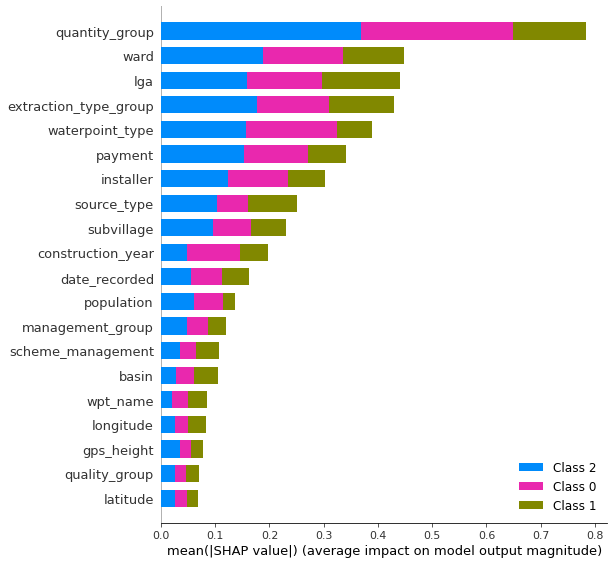

In [225]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(imputed_X_train_final)

shap.summary_plot(shap_values, imputed_X_train_final)